# Required libraries

In [2]:
# Importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import geopandas as gpd
import folium


# Data Preprocessing

In [3]:
# Loading data into dataframes
file1 = pd.ExcelFile("C:/Users/krish/Desktop/MODEL 5/flood risk data_new.xlsx")
file2 = pd.ExcelFile("C:/Users/krish/Desktop/MODEL 5/IMD_L1.xlsx")

# Parsing the sheets into dataframes
df1 = file1.parse('Sheet1')
df2 = file2.parse('Sheet1')

# Merging the datasets based on the column 'LADnm' (Local Authority District Name)
merged_df = pd.merge(df1, df2, on='LADnm', how='inner')

# Saving the merged dataset to a new file
output_path = "C:/Users/krish/Desktop/MODEL 5/merged_data_model5.csv"
merged_df.to_csv(output_path, index=False)

print(f"Merged data saved to {output_path}")


Merged data saved to C:/Users/krish/Desktop/MODEL 5/merged_data_model5.csv


In [4]:
# Loading the merged dataset
df = pd.read_csv("C:/Users/krish/Desktop/MODEL 5/merged_data_model5.csv")

print(df.head())


          LADnm  Residential Properties At High Risk (%)  \
0          Adur                                  0.70873   
1  Amber Valley                                  0.29139   
2          Arun                                  0.35502   
3      Ashfield                                  0.09971   
4       Babergh                                  0.16684   

   Non-residential Properties At High Risk (%)  \
0                                      0.15447   
1                                      0.34485   
2                                      0.33986   
3                                      0.02266   
4                                      0.09606   

   Unclassified Properties At High Risk (%)  \
0                                   0.02726   
1                                   0.10426   
2                                   0.02706   
3                                   0.01209   
4                                   0.11291   

   Residential Properties At Medium Risk (%)  \
0      

# Objective 1: Quantifying the number of people and properties at risk

In [5]:
# Calculating the total for all risk levels for each property type
df['Total Residential Properties Risk (%)'] = (
    df['Residential Properties At High Risk (%)'] +
    df['Residential Properties At Medium Risk (%)'] +
    df['Residential Properties At Low Risk (%)'] +
    df['Residential Properties At Very Low Risk (%)']
)

df['Total Non-Residential Properties Risk (%)'] = (
    df['Non-residential Properties At High Risk (%)'] +
    df['Non-residential Properties At Medium Risk (%)'] +
    df['Non-residential Properties At Low Risk (%)'] +
    df['Non-residential Properties At Very Low Risk (%)']
)

df['Total Unclassified Properties Risk (%)'] = (
    df['Unclassified Properties At High Risk (%)'] +
    df['Unclassified Properties At Medium Risk (%)'] +
    df['Unclassified Properties At Low Risk (%)'] +
    df['Unclassified Properties At Low Risk (%)']
)


# Calculating the total risk across all property types
df['Total Property Risk (%)'] = (
    df['Total Residential Properties Risk (%)'] +
    df['Total Non-Residential Properties Risk (%)'] +
    df['Total Unclassified Properties Risk (%)'] +
    df['Deprived Properties At Risk Total (%)']
)

risk_summary = df.groupby('LADnm').agg({
    'People At Risk Total (%)': 'sum',
    'Total Residential Properties Risk (%)': 'sum',
    'Total Non-Residential Properties Risk (%)': 'sum',
    'Total Unclassified Properties Risk (%)': 'sum',
    'Deprived Properties At Risk Total (%)': 'sum'
}).reset_index()

print("\nFlood Risk Summary by Region:")
print(risk_summary.head())


Flood Risk Summary by Region:
          LADnm  People At Risk Total (%)  \
0          Adur                  15.43544   
1  Amber Valley                   3.12300   
2          Arun                   7.80610   
3      Ashfield                   1.19143   
4       Babergh                   1.33233   

   Total Residential Properties Risk (%)  \
0                               13.85044   
1                                2.62113   
2                                6.77888   
3                                1.06209   
4                                1.03978   

   Total Non-Residential Properties Risk (%)  \
0                                    1.99897   
1                                    1.02119   
2                                    2.81308   
3                                    0.14655   
4                                    0.30166   

   Total Unclassified Properties Risk (%)  \
0                                 0.43614   
1                                 0.45045   
2        

# Objective 2: Characterizing socio-economic vulnerabilities associated with flood risks


Flood Vulnerability by Region:
          LADnm  Flood Vulnerability for DepChi  \
0          Adur                        1.134864   
1  Amber Valley                        0.214198   
2          Arun                        0.516402   
3      Ashfield                        0.116351   
4       Babergh                        0.079791   

   Flood Vulnerability for Pop60+  Flood Vulnerability for Pop16_59  \
0                        1.839090                          3.364482   
1                        0.350367                          0.703471   
2                        1.128757                          1.607896   
3                        0.150317                          0.351780   
4                        0.145224                          0.235663   

   Flood Vulnerability for WorkPop  
0                         3.402098  
1                         0.714353  
2                         1.643321  
3                         0.355330  
4                         0.239318  


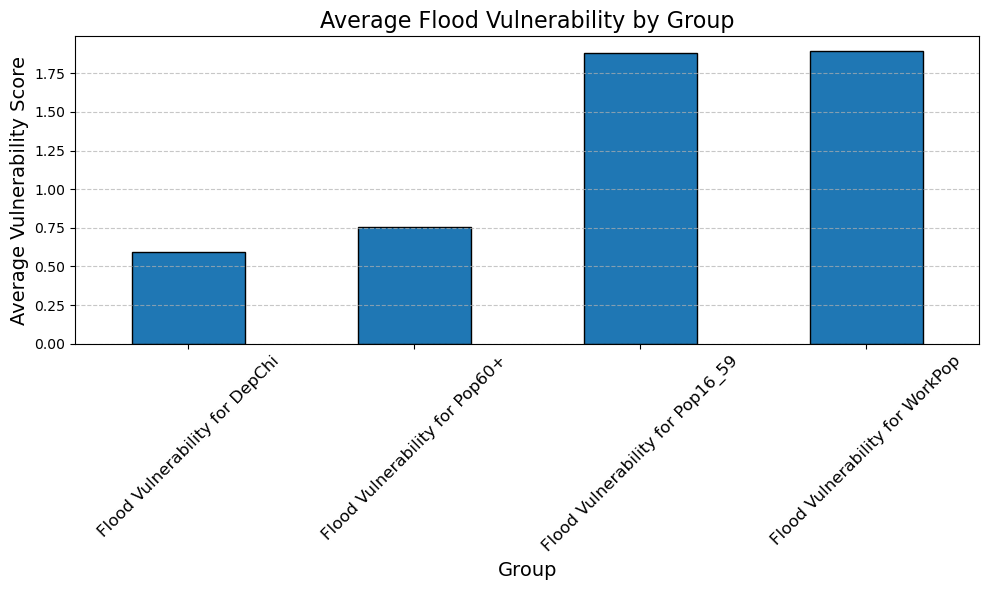

In [6]:
# Normalizing required columns for deprivation and risk analysis
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalizing the deprivation indices data and people at risk data
columns_to_normalize = [
    'IncScore', 'EmpScore', 'EduScore', 'HDDScore', 'EnvScore', 'BHSScore', 'People At Risk Total (%)'
]

for col in columns_to_normalize:
    df[f'{col}_Normalized'] = normalize(df[col])

# Calculating Social Vulnerability Index (SVI) as the average of normalized deprivation indices
df['SVI'] = df[
    ['IncScore_Normalized', 'EmpScore_Normalized', 'EduScore_Normalized',
     'HDDScore_Normalized', 'EnvScore_Normalized', 'BHSScore_Normalized']
].mean(axis=1)

# Calculating flood risk for each group (DepChi (Dependent children), Pop60+ (Population aged 60+), Pop16_59 (Population aged inbetween 16 to 59), WorkPop (Working population))
groups = ['DepChi', 'Pop60+', 'Pop16_59', 'WorkPop']
for group in groups:
    df[f'Flood Risk for {group}'] = (
        df['People At Risk Total (%)'] * (df[group] / df['TotPop'])
    )

# Calculating flood vulnerability using flood risk and SVI
for group in groups:
    df[f'Flood Vulnerability for {group}'] = (
        df[f'Flood Risk for {group}'] * df['SVI']
    )

# Grouping and aggregating vulnerability results
grouped_vulnerability = df.groupby('LADnm').agg({
    f'Flood Vulnerability for {groups[0]}': 'sum',
    f'Flood Vulnerability for {groups[1]}': 'sum',
    f'Flood Vulnerability for {groups[2]}': 'sum',
    f'Flood Vulnerability for {groups[3]}': 'sum'
}).reset_index()

print("\nFlood Vulnerability by Region:")
print(grouped_vulnerability.head())

# Preparing data for visualization
vulnerability_columns = [f'Flood Vulnerability for {group}' for group in groups]
vulnerability_data = df[vulnerability_columns].mean().sort_values()

# Plotting the average vulnerability for each group
plt.figure(figsize=(10, 6))
vulnerability_data.plot(kind='bar', edgecolor='black')
plt.title('Average Flood Vulnerability by Group', fontsize=16)
plt.ylabel('Average Vulnerability Score', fontsize=14)
plt.xlabel('Group', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


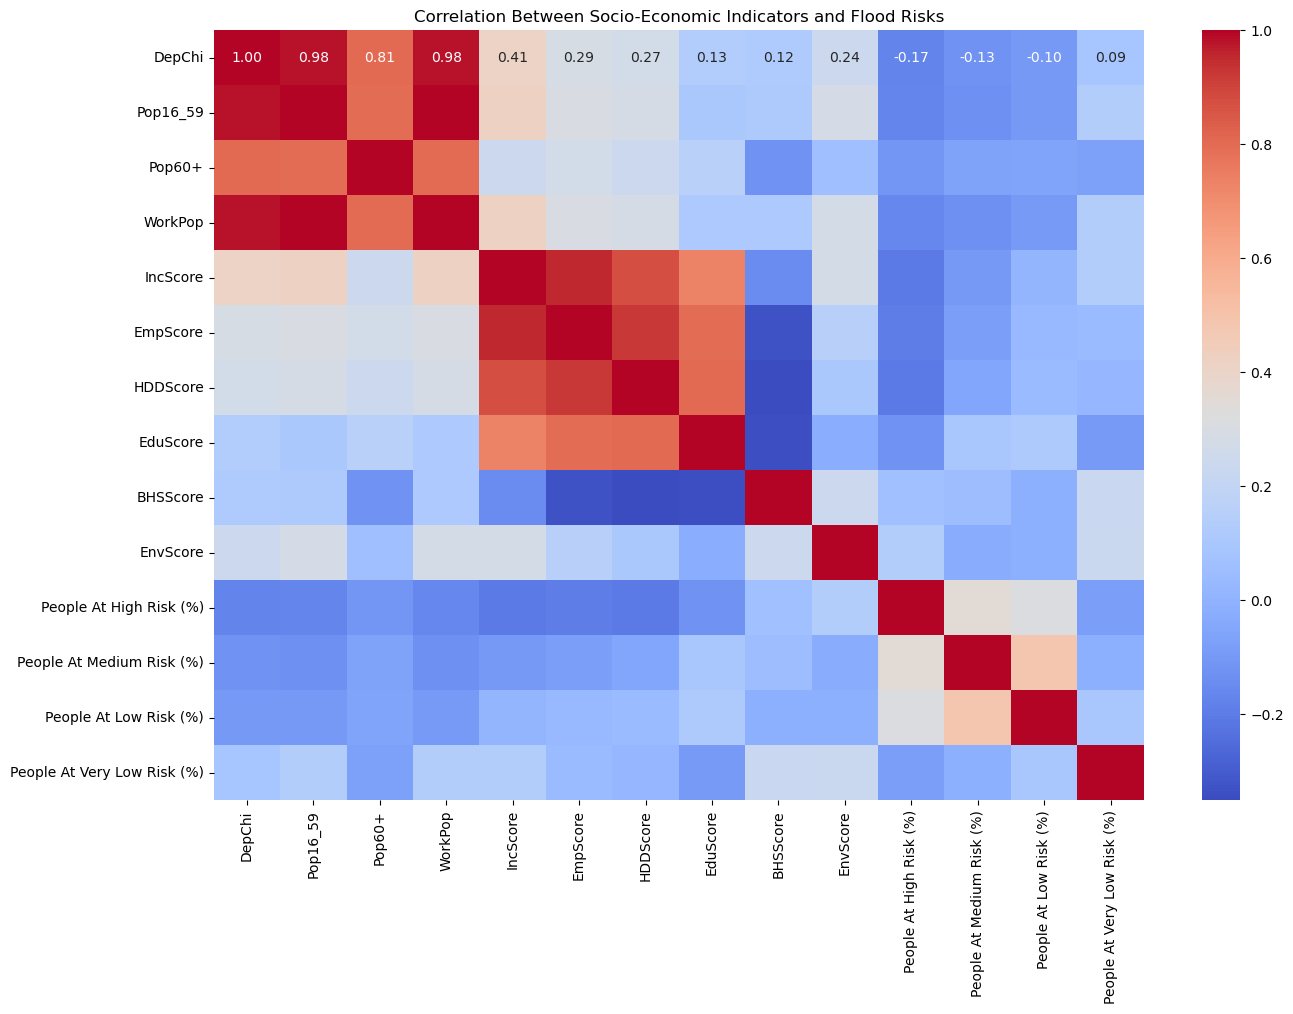

In [7]:
# Defining relevant indicators
socioeconomic_indicators = [
    'DepChi', 'Pop16_59', 'Pop60+', 'WorkPop',  # Demographic
    'IncScore', 'EmpScore', 'HDDScore', 'EduScore',  # Socio-Economic Deprivation
    'BHSScore',  # Housing and Services
    'EnvScore'
]

flood_risk_indicators = [
    'People At High Risk (%)',
    'People At Medium Risk (%)',
    'People At Low Risk (%)',
    'People At Very Low Risk (%)',
]

# Subset data
relevant_columns = socioeconomic_indicators + flood_risk_indicators
subset_data = df[relevant_columns]

# Analyzing correlations
correlation_matrix = subset_data.corr()

# Visualizing correlations
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Socio-Economic Indicators and Flood Risks")
plt.show()


# Objective 3(A): Model the impact of flooding on populations.

Cross-Validation Accuracy: 0.84 ± 0.04
Confusion Matrix:
[[12  1  0  0]
 [ 2 10  2  0]
 [ 0  3  9  1]
 [ 0  0  2 12]]

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.92      0.89        13
           2       0.71      0.71      0.71        14
           3       0.69      0.69      0.69        13
           4       0.92      0.86      0.89        14

    accuracy                           0.80        54
   macro avg       0.80      0.80      0.80        54
weighted avg       0.80      0.80      0.80        54

Accuracy: 0.80


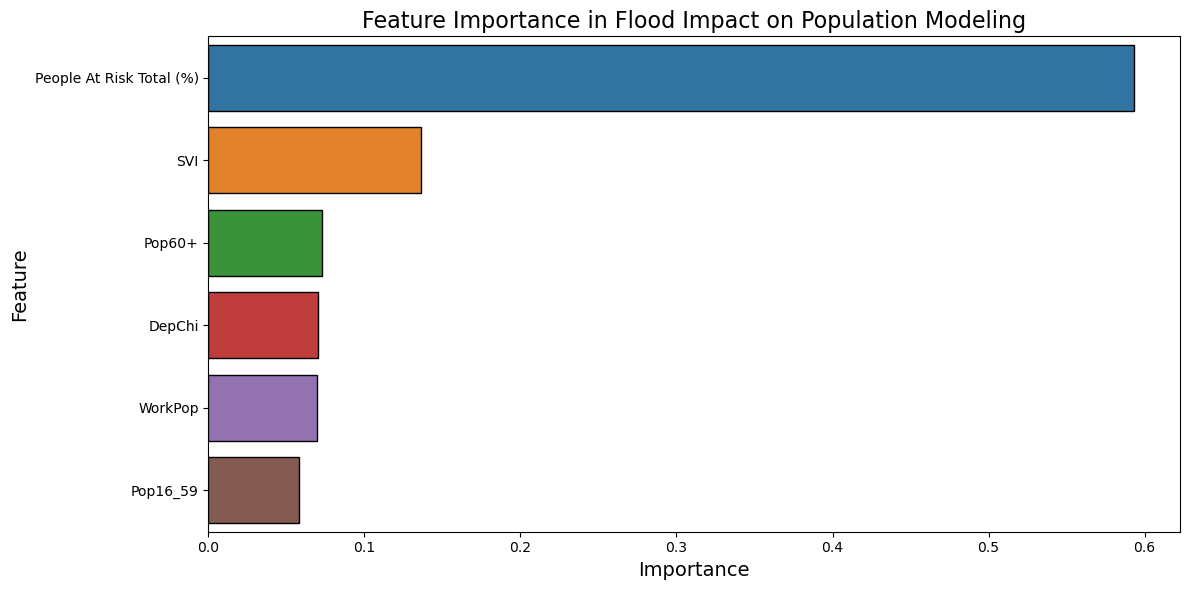

In [8]:
# Using a combination of normalized SVI and overall flood risk (people)
df['Impact level on population'] = pd.qcut(
    df['People At Risk Total (%)'] * df['SVI'], 
    q=4, labels=['1', '2', '3', '4']
)

# Defining the features and the target
features = ['People At Risk Total (%)', 'SVI', 'DepChi', 'Pop60+', 'Pop16_59', 'WorkPop']
target = 'Impact level on population'

X = df[features]
y = df[target]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initializing and training the Random Forest Classifier with cross-validation
rfc = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfc, X_train, y_train, cv=cv, scoring='accuracy')

print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Fitting the model on the training set
rfc.fit(X_train, y_train)

# Predicting on the test data
y_pred = rfc.predict(X_test)

# Confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Feature importance
importances = rfc.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plotting feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', edgecolor='black')
plt.title('Feature Importance in Flood Impact on Population Modeling', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()


# Objective 3(B): Model the impact of flooding on critical infrastructure.

Cross-Validation Accuracy: 0.94 ± 0.02
Confusion Matrix:
[[12  1  0  0]
 [ 0 12  2  0]
 [ 0  0 13  0]
 [ 0  0  1 13]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.92      0.96        13
           2       0.92      0.86      0.89        14
           3       0.81      1.00      0.90        13
           4       1.00      0.93      0.96        14

    accuracy                           0.93        54
   macro avg       0.93      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54

Accuracy: 0.93


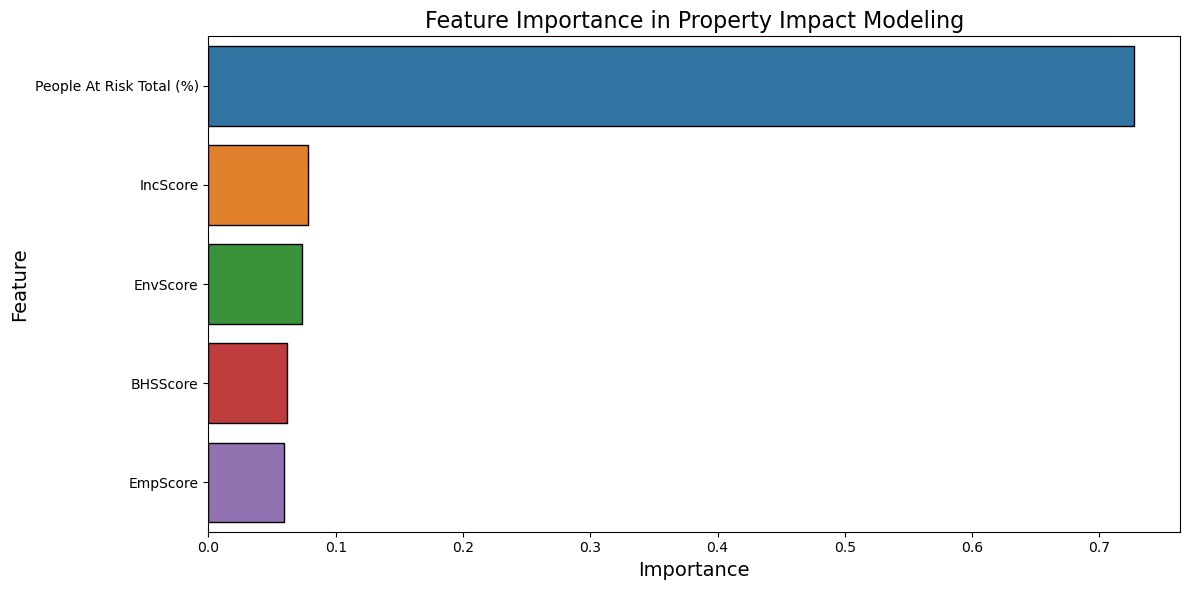

In [9]:
# Defining the target variable
df['Residential Property Impact Level'] = pd.qcut(
    df['Total Residential Properties Risk (%)'], q=4, labels=['1', '2', '3', '4']
)

# Defining features and target
features = ['People At Risk Total (%)', 'IncScore', 'EmpScore', 'EnvScore', 'BHSScore']
target = 'Residential Property Impact Level'

X = df[features]
y = df[target]

# Normalizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Initializing and training the Random Forest Classifier
rfc = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rfc.fit(X_train, y_train)

# Cross-validation to evaluate model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfc, X_scaled, y, cv=cv, scoring='accuracy')

print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Predicting on test data
y_pred = rfc.predict(X_test)

# Confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Feature importance
importances = rfc.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plotting feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', edgecolor='black')
plt.title('Feature Importance in Property Impact Modeling', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()


# Preparing the results for each objective and saving them into a CSV

In [10]:
# Objective 1: Quantify the number of people and properties at risk
objective_1_results = df.groupby('LADnm').agg({
    'People At Risk Total (%)': 'sum',
    'Total Residential Properties Risk (%)': 'sum',
    'Total Non-Residential Properties Risk (%)': 'sum',
    'Total Unclassified Properties Risk (%)': 'sum',
    'Deprived Properties At Risk Total (%)': 'sum'
}).reset_index()

# Objective 2: Socio-economic vulnerabilities and flood vulnerabilities
objective_2_results = df.groupby('LADnm').agg({
    'Flood Vulnerability for DepChi': 'sum',
    'Flood Vulnerability for Pop60+': 'sum',
    'Flood Vulnerability for Pop16_59': 'sum',
    'Flood Vulnerability for WorkPop': 'sum',
    'SVI': 'mean'  # Average Social Vulnerability Index
}).reset_index()

# Objective 3: Impact of flooding
objective_3_results = df[['LADnm', 'Impact level on population', 'Residential Property Impact Level']].copy()

# Merging all results into a single file
combined_results = objective_1_results.merge(
    objective_2_results, on='LADnm', how='left'
).merge(
    objective_3_results, on='LADnm', how='left'
)

# Saving the results to a CSV file
output_file_path = "C:/Users/krish/Desktop/MODEL 5/flood_risk_analysis_results.csv"
combined_results.to_csv(output_file_path, index=False)

output_file_path


'C:/Users/krish/Desktop/MODEL 5/flood_risk_analysis_results.csv'

### ^^^ This newly created CSV contains the results ^^^

# Integrating Results CSV and Geographic data to visualize maps

In [11]:
# File paths
geojson_path = 'C:/Users/krish/Desktop/MODEL 5/IMD_L1.geojson'
csv_path = 'C:/Users/krish/Desktop/MODEL 5/flood_risk_analysis_results.csv'
output_html_path = 'C:/Users/krish/Desktop/MODEL 5/flood_risk_map_with_impact_levels.html'

# Loading the GeoJSON and CSV data
geojson_data = gpd.read_file(geojson_path)
ladnm_data = pd.read_csv(csv_path)

# Merging the GeoJSON and CSV data
merged_gdf = geojson_data.merge(ladnm_data, how="left", on="LADnm")

# Creating the Folium map
m = folium.Map(location=[55.0, -2.0], zoom_start=6)

# Add base map
folium.TileLayer(
    tiles="https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png",
    attr="© OpenStreetMap contributors © CARTO",
    name="Flood Risk Visualization Map",
    overlay=False,
    control=True
).add_to(m)

# Adding GeoJSON layer with tooltips 
geojson_layer = folium.GeoJson(
    merged_gdf,
    name="GeoJson Layer",
    tooltip=folium.GeoJsonTooltip(
        fields=["LADnm", "People At Risk Total (%)", "Total Residential Properties Risk (%)",
                "Total Non-Residential Properties Risk (%)", "Total Unclassified Properties Risk (%)",
                "SVI", "Flood Vulnerability for DepChi", "Flood Vulnerability for Pop60+",
                "Flood Vulnerability for Pop16_59", "Flood Vulnerability for WorkPop",
                "Impact level on population", "Residential Property Impact Level"],
        aliases=["Region:", "People At Risk (%):", "Residential Risk (%):", "Non-Residential Risk (%):",
                 "Unclassified Risk (%):", "Social Vulnerability Index:", "Vulnerability (DepChi):",
                 "Vulnerability (Pop60+):", "Vulnerability (Pop16_59):", "Vulnerability (WorkPop):",
                 "Impact Level on Population:", "Residential Property Impact Level:"],
        localize=True,
    ),
).add_to(m)

# Adding layers for each result column
result_columns = [
    "People At Risk Total (%)",
    "Total Residential Properties Risk (%)",
    "Total Non-Residential Properties Risk (%)",
    "Total Unclassified Properties Risk (%)",
    "SVI",
    "Flood Vulnerability for DepChi",
    "Flood Vulnerability for Pop60+",
    "Flood Vulnerability for Pop16_59",
    "Flood Vulnerability for WorkPop",
    "Impact level on population",
    "Residential Property Impact Level"
]

colors = [
    "YlGn", "YlOrBr", "OrRd", "PuRd", "Blues", "Oranges", "Greens", "Purples", "RdYlBu", "YlGnBu", "YlOrRd"
]

for col, color in zip(result_columns, colors):
    folium.Choropleth(
        geo_data=merged_gdf,
        data=merged_gdf,
        columns=["LADnm", col],
        key_on="feature.properties.LADnm",
        fill_color=color,
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=col,
        name=col,
    ).add_to(m)

# Adding layer control
folium.LayerControl(collapsed=False).add_to(m)

# Saving the updated map as an HTML file
m.save(output_html_path)

output_html_path


'C:/Users/krish/Desktop/MODEL 5/flood_risk_map_with_impact_levels.html'

### ^^^ Open the above created HTML file to view the interactive map with results (might take some time to load)